In [1]:
''' autor: Jazielinho '''

' autor: Jazielinho '

## Identificación de dígitos con Tensorflow

En este tutorial crearemos un modelo para reconocer dígitos escritos a mano usando Tensorflow y Python.

### Importando librerías

Vamos a usar las siguientes librerías:

* Pandas para el análisis de datos.
* Tensorflow para la construcción de nuestro modelo Deep Learning.
* Sklearn para evaluación de nuestros modelos.
* Matplotlib, seaborn para visualizar.
* Lime para entender qué ha decidido el modelo de Tensorflow.

In [2]:
import pandas as pd
import tensorflow as tf
import random
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from skimage.segmentation import mark_boundaries
from skimage.color import label2rgb
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
import pickle
import umap
import dill

import config

In [3]:
%matplotlib inline

In [4]:
BATCH_SIZE = 512

### Descargando los datos

Para poder entrenar nuestros modelos vamos a descargar los datos desde Tensorflow

In [5]:
(X, y), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

Vamos a ver el tamaño de nuestros datos

In [6]:
print(f"Tamaño de nuestros datos de entrenamiento: {X.shape}")
print(f"Tamaño de nuestros datos de test: {X.shape}")

Tamaño de nuestros datos de entrenamiento: (60000, 28, 28)
Tamaño de nuestros datos de test: (60000, 28, 28)


Al tratarse de imágenes vamos a añadir una nueva dimension

In [7]:
X = X.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

In [8]:
print(f"Tamaño de los datos: {X.shape}, target: {y.shape}")

Tamaño de los datos: (60000, 28, 28, 1), target: (60000,)


In [9]:
print(f"Tamaño de los datos de test: {X_test.shape}, target: {y_test.shape}")

Tamaño de los datos de test: (10000, 28, 28, 1), target: (10000,)


### Conjunto de entrenamiento y validacion

Para poder evaluar si el comportamiento de nuestro modelo es el correcto, vamos a dividir nuestros datos en conjunto de entrenamiento y validación.
Nuestro conjunto de validación será del 20% del total de nuestros datos.

In [10]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=123456)

In [11]:
print(f"Tamaño de los datos de entrenamiento: {X_train.shape}, target: {y_train.shape}")

Tamaño de los datos de entrenamiento: (48000, 28, 28, 1), target: (48000,)


In [12]:
print(f"Tamaño de los datos de validacion: {X_val.shape}, target: {y_val.shape}")

Tamaño de los datos de validacion: (12000, 28, 28, 1), target: (12000,)


### Preparando los datos

Por lo general, una imagen tienen 3 canales: RGB. En este caso, nuestras imágenes, al estar en escala de grises, solo tienen un canal. Para Lime es necesario que las imágenes estén en los 3 canales. Lo que haremos es replicar los valores en los 3 canales RGB. La siguiente función realiza lo siguiente:

In [13]:
def to_rgb(x):
    # Convierte una imagen de un canal a los 3 canales: RGB
    x_rgb = np.zeros((x.shape[0], 28, 28, 3))
    for i in range(3):
        x_rgb[..., i] = x[..., 0]
    return x_rgb

In [14]:
X_train = to_rgb(X_train)
X_val = to_rgb(X_val)
X_test = to_rgb(X_test)
X_train = X_train.reshape(-1, 28, 28, 3)
X_val = X_val.reshape(-1, 28, 28, 3)
X_test = X_test.reshape(-1, 28, 28, 3)
y_train = tf.keras.utils.to_categorical(y_train, num_classes = 10)
y_val = tf.keras.utils.to_categorical(y_val, num_classes = 10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes = 10)

In [15]:
X_train.shape

(48000, 28, 28, 3)

Podemos ver que nuestras imágenes ya están en los 3 canales, aunque se repitan los valores.

### Analizando algunos datos

Vamos a analizar algunas imágenes de nuestro conjunto de entrenamiento

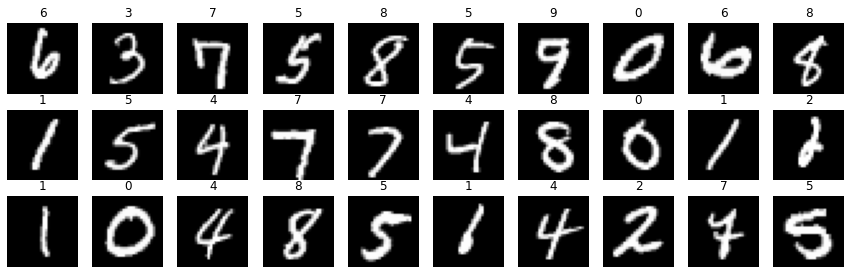

In [16]:
# Seleccionamos una muestra de nuestro conjunto de entrenamiento
index_train = list(range(len(X_train)))
random.shuffle(index_train)

# Graficamos
plt.figure(figsize=(15, 4.5))
for i in range(30):
    plt.subplot(3, 10, i+1)
    plt.imshow(X_train[index_train[i]].astype(np.uint8), cmap=plt.cm.binary)
    plt.title(np.argmax(y_train[index_train[i]]))
    plt.axis('off')
plt.show()

Podemos ver que hay imágenes que pueden ser fáciles de clasificar, pero otros muy difíciles. En la fase de evaluación veremos si nuestro modelo puede reconocer o no estos casos.

### Aumento de datos

Nuestro conjunto de datos está compuesta de 48 mil imágenes. Si queremos que nuestro modelo sea robusto, necesitamos muchos ejemplos, en este caso, muchas imágenes. 
Una de las técnicas para generar más imágenes, de una dada, es usar "aumento de datos" https://keras.io/api/preprocessing/image/
La siguiente imagen muestra un ejemplo de aumento de datos. A partir de una imagen, generamos muchas imágenes realizando transformaciones como rotación, traslación, ...

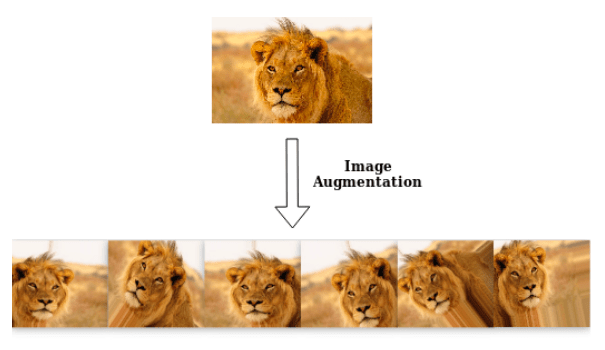

En este caso, vamos a aplicar rotación, zoom y traslación, tanto horizontal como vertical:

In [17]:
tr_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    zoom_range = 0.1,
    width_shift_range=0.1,
    height_shift_range=0.1)

Veamos algunos ejemplos

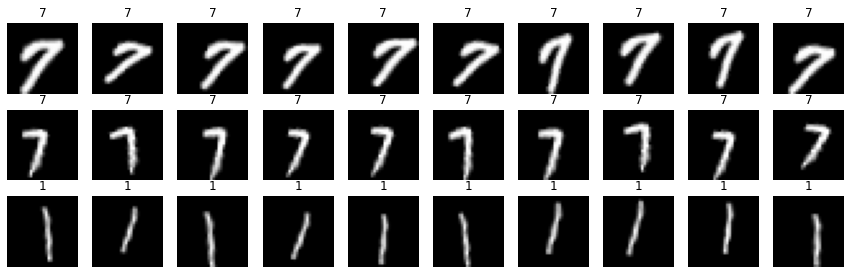

In [18]:
random.shuffle(index_train)

X_sample = X_train[index_train[0],].reshape((1, 28, 28, 3))
y_sample = y_train[index_train[0],].reshape((1, 10))

plt.figure(figsize=(15,4.5))
for i in range(30):
    plt.subplot(3, 10, i+1)
    X_plot, Y_plot = tr_datagen.flow(X_sample, y_sample).next()
    plt.imshow(X_plot[0].astype(np.uint8), cmap=plt.cm.binary)
    plt.title(np.argmax(y_sample))
    plt.axis('off')
    if i==9:
        X_sample = X_train[index_train[1],].reshape((1, 28, 28, 3))
        y_sample = y_train[index_train[1],].reshape((1, 10))
    if i==19:
        X_sample = X_train[index_train[2],].reshape((1, 28, 28, 3))
        y_sample = y_train[index_train[2],].reshape((1, 10))


plt.show()

In [19]:
train_datagen = tr_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE)

### Definiendo el modelo

In [20]:
def get_model():
    model = tf.keras.Sequential()
    
    model.add(tf.keras.layers.Conv2D(32, kernel_size=3, activation='relu', input_shape=(28, 28, 3)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2D(32, kernel_size=3, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2D(32, kernel_size=5, strides=2, padding='same', activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.4))
    
    model.add(tf.keras.layers.Conv2D(64, kernel_size=3, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2D(64, kernel_size=3, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2D(64, kernel_size=5, strides=2, padding='same', activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.4))
    
    model.add(tf.keras.layers.Conv2D(128, kernel_size=4, activation='relu', name='last_conv'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dropout(0.4))
    model.add(tf.keras.layers.Dense(10, name='embedding'))
    
    model.add(tf.keras.layers.Activation('softmax'))
    
    return model

In [21]:
model = get_model()

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 26, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 32)        25632     
_________________________________________________________________
batch_normalization_2 (Batch (None, 12, 12, 32)        128       
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 32)        0

In [23]:
model.compile(
    loss='categorical_crossentropy',
    metrics=['accuracy'],
    optimizer='adam')

### Entrenando modelo

In [24]:
es = tf.keras.callbacks.EarlyStopping(min_delta=0.001, patience=10, verbose=1, restore_best_weights=True)
rlr = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-10, verbose=1)

In [25]:
history = model.fit(train_datagen,
                    epochs=1000,
                    steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
                    validation_data=(X_val, y_val),
                    callbacks=[es, rlr],
                    verbose=2)

Epoch 1/1000
93/93 - 13s - loss: 0.9101 - accuracy: 0.7249 - val_loss: 0.2852 - val_accuracy: 0.9158
Epoch 2/1000
93/93 - 13s - loss: 0.2204 - accuracy: 0.9346 - val_loss: 0.1291 - val_accuracy: 0.9607
Epoch 3/1000
93/93 - 12s - loss: 0.1408 - accuracy: 0.9577 - val_loss: 0.1164 - val_accuracy: 0.9673
Epoch 4/1000
93/93 - 12s - loss: 0.1102 - accuracy: 0.9671 - val_loss: 0.0665 - val_accuracy: 0.9803
Epoch 5/1000
93/93 - 12s - loss: 0.0896 - accuracy: 0.9732 - val_loss: 0.0499 - val_accuracy: 0.9847
Epoch 6/1000
93/93 - 13s - loss: 0.0821 - accuracy: 0.9751 - val_loss: 0.0421 - val_accuracy: 0.9883
Epoch 7/1000
93/93 - 12s - loss: 0.0732 - accuracy: 0.9785 - val_loss: 0.0383 - val_accuracy: 0.9893
Epoch 8/1000
93/93 - 13s - loss: 0.0672 - accuracy: 0.9802 - val_loss: 0.0418 - val_accuracy: 0.9878
Epoch 9/1000
93/93 - 12s - loss: 0.0633 - accuracy: 0.9811 - val_loss: 0.0394 - val_accuracy: 0.9875
Epoch 10/1000
93/93 - 12s - loss: 0.0590 - accuracy: 0.9817 - val_loss: 0.0344 - val_accura

### Evaluando el modelo

#### Comportamiento de la pérdida en el conjunto de entrenamiento y validación:

<AxesSubplot:>

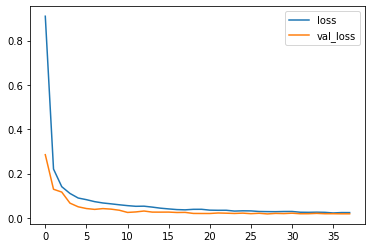

In [26]:
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()

#### Comportamiento de la precisión en el conjunto de entrenamiento y validación:

<AxesSubplot:>

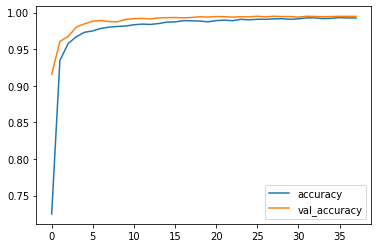

In [27]:
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()

#### Predicción del modelo en el conjunto de test:

In [28]:
predict_test = model.predict(X_test, verbose=0)
predict_class = np.argmax(predict_test, axis=1)

data_test = pd.DataFrame({'pred': predict_class, 'target': np.argmax(y_test, axis=1)})

In [29]:
data_test.head()

,pred,target
0,7,7
1,2,2
2,1,1
3,0,0
4,4,4


Matriz de confusión en el conjunto de test

In [30]:
cf_matrix = confusion_matrix(data_test['target'], data_test['pred'])

<AxesSubplot:>

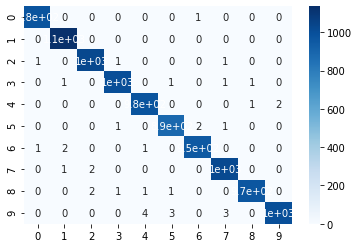

In [31]:
sns.heatmap(cf_matrix, annot=True, cmap='Blues')

Analizando los casos mal clasificados:

In [32]:
index_error = data_test[data_test['target'] != data_test['pred']].index.tolist()

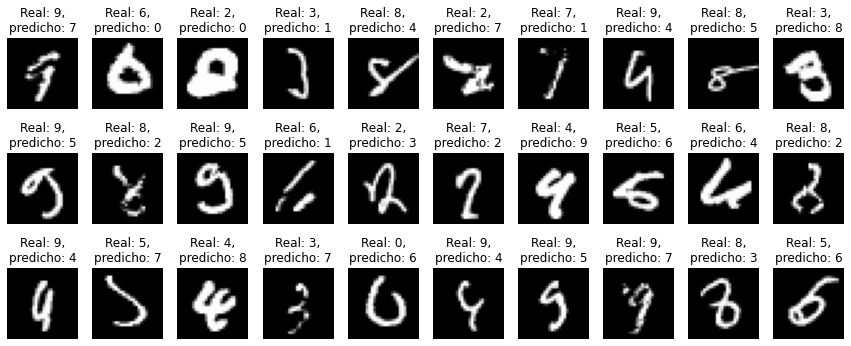

In [33]:
random.shuffle(index_error)

plt.figure(figsize=(15, 6))
for i in range(30):
    if i < len(index_error):
        real_ = np.argmax(y_test[index_error[i]])
        pred_ = predict_class[index_error[i]]
        plt.subplot(3, 10, i+1)
        plt.imshow(X_test[index_error[i]].astype(np.uint8), cmap=plt.cm.binary)
        plt.title(f"Real: {real_},\npredicho: {pred_}")
        plt.axis('off')
plt.show()

### LIME para importancia

Para entender los motivos de las decisiones que ha tenido en cuenta nuestra red neuronal, usamos la librería LIME. Hay que tener en cuenta que el análisis es individual, tenemos que analizar imagen por imagen.

Para entender un poco el funcionamiento de esta librería:

https://github.com/marcotcr/lime

In [34]:
explainer = lime_image.LimeImageExplainer(verbose=False, random_state=12345)
segmenter = SegmentationAlgorithm('quickshift', kernel_size=1, max_dist=200, ratio=0.2)

Probamos con una imagen en particular:

In [35]:
X_eval = X_test[index_error[10]]

Solicitamos los motivos de decisión:

In [36]:
explanation = explainer.explain_instance(X_eval, 
                                         classifier_fn=model.predict,
                                         top_labels=10, 
                                         hide_color=0,
                                         num_samples=10000, 
                                         segmentation_fn=segmenter)

Vamos a visualizar las decisiones por cada categoría. Los colores rojos indican los pixeles que ha tenido en cuenta nuestra red neuronal:

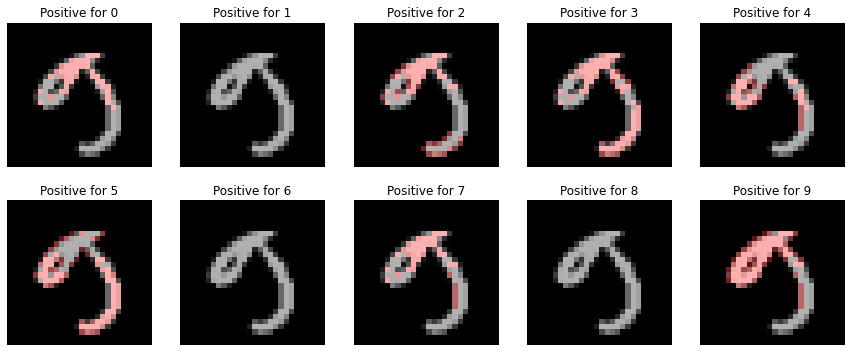

In [37]:
plt.figure(figsize=(15, 6))

for i in range(10):
    temp, mask = explanation.get_image_and_mask(i, positive_only=True, num_features=1000, hide_rest=False, min_weight=0.01)
    plt.subplot(2, 5, i+1)
    plt.imshow(label2rgb(mask.astype(np.uint8), X_eval.astype(np.uint8), bg_label = 0), interpolation = 'nearest')
    plt.title('Positive for {}'.format(i))
    plt.axis('off')

plt.show()

Veamos las decisiones para la predicción de nuestra red neuronal. De la imagen anterior vemos que nuestro modelo da mayor probabilidad de que la imagen sea un 9 que un 4.

In [38]:
clase_predicha = model.predict(X_eval.reshape((1, 28, 28, 3))).argmax(axis=1)[0]

image, mask = explanation.get_image_and_mask(
    clase_predicha,
    positive_only=True,
    hide_rest=False)

Text(0.5, 1.0, 'Positive for 5')

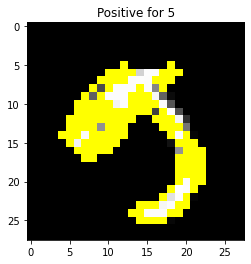

In [39]:
plt.imshow(X_eval.astype(np.uint8))
plt.imshow(mark_boundaries(image.astype(np.uint8), mask))
plt.title('Positive for {}'.format(clase_predicha))

### Reducción de dimensiones usando UMAP

Lo que vamos a hacer a continuación es visualizar la predicción de nuestra red neuronal en nuestro conjunto de entrenamiento y conjunto de validación. Usaremos la capa **embedding**

In [40]:
emb_model = tf.keras.models.Model(model.input, model.get_layer('embedding').output)

In [41]:
emb_train = emb_model.predict(X_train, verbose=1)
emb_val = emb_model.predict(X_val, verbose=1)
emb_test = emb_model.predict(X_test, verbose=1)

313/313 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 2ms/step


Creamos nuestro objeto umap y entrenamos en nuestro conjunto de entrenamiento:

In [42]:
umap_model = umap.UMAP(random_state=42, metric='cosine')

umap_train = umap_model.fit_transform(emb_train)

In [43]:
umap_train_df = pd.DataFrame(umap_train, columns=['x0', 'x1'])
umap_train_df['target'] = y_train.argmax(axis=1)

Visualizando nuestros datos en dos dimensiones:

<AxesSubplot:xlabel='x0', ylabel='x1'>

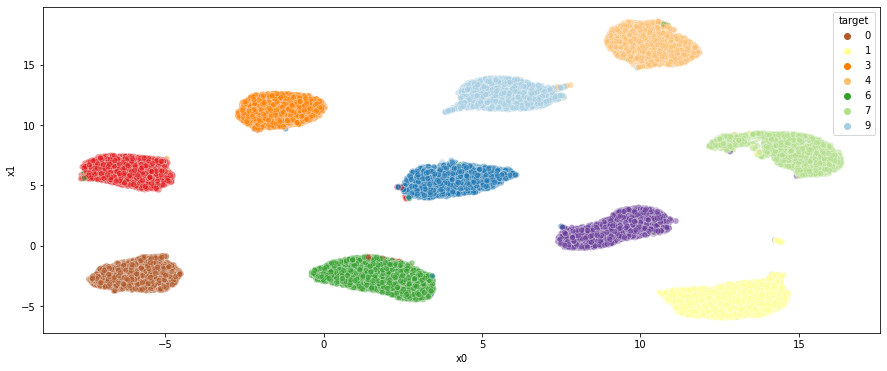

In [44]:
plt.figure(figsize=(15, 6))
sns.scatterplot(x="x0", y="x1", alpha=0.5, hue="target", data=umap_train_df, palette='Paired_r')

Prediciendo en nuestro conjunto de test:

In [45]:
umap_test = umap_model.transform(emb_test)

In [46]:
umap_test_df = pd.DataFrame(umap_test, columns=['x0', 'x1'])
umap_test_df['target'] = y_test.argmax(axis=1)

<AxesSubplot:xlabel='x0', ylabel='x1'>

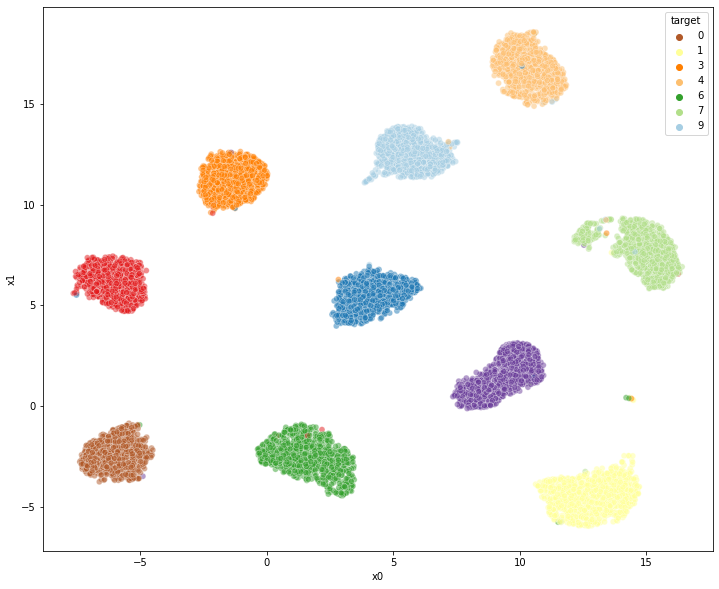

In [47]:
plt.figure(figsize=(12, 10))
sns.scatterplot(x="x0", y="x1", alpha=0.5, hue="target", data=umap_test_df, palette='Paired_r')

### Buscando imagenes similares

Otra manera de poder analizar las decisiones que ha tomado nuestra red neuronal es buscando imágenes parecidas. Para esto haremos uso de sklearn y el algoritmo de vecinos próximos

In [48]:
nbrs = NearestNeighbors(n_neighbors=5, metric='cosine')
nbrs.fit(emb_train)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

Vamos a buscar imágenes similares en nuestro conjunto de test:

In [49]:
distances_test, pred_nearest_test = nbrs.kneighbors(emb_test)

Analicemos algunas imágenes de test:

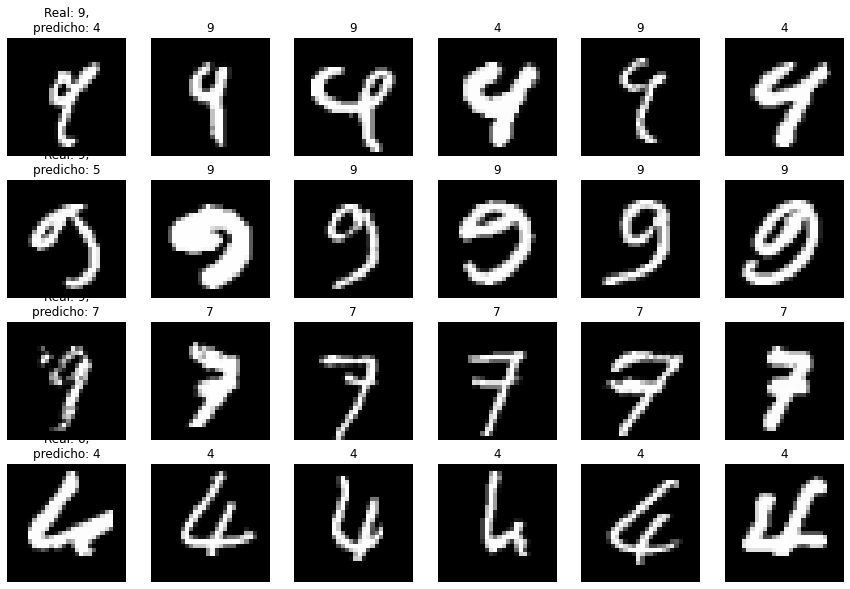

In [50]:
random.shuffle(index_error)

plt.figure(figsize=(15, 10))

k = 0

for i in range(4):
    test_plot = X_test[index_error[i]]
    similars = pred_nearest_test[index_error[i],:].ravel()
    real_ = np.argmax(y_test[index_error[i]])
    pred_ = predict_class[index_error[i]]
    
    for j in range(6):
        k += 1
        plt.subplot(4, 6, k)
        if j == 0:
            plt.imshow(X_test[index_error[i]].astype(np.uint8))
            plt.title(f"Real: {real_},\npredicho: {pred_}")
        else:
            plt.imshow(X_train[similars[(j - 1)]].astype(np.uint8), cmap=plt.cm.binary)
            plt.title(np.argmax(y_train[similars[(j - 1)]]))
        plt.axis('off')
plt.show()

### GUARDANDO MODELOS

Vamos a guardar los modelos:
* Red neuronal
* umap
* vecinos cercanos

In [51]:
model_json = model.to_json()
with open(config.MODEL_PATH_JSON, 'w') as json_file:
    json_file.write(model_json)
model.save_weights(config.MODEL_PATH_H5)

In [52]:
with open(config.MODEL_EXPLAINER, 'wb') as explainer_file:
    dill.dump(explainer, explainer_file)

with open(config.MODEL_SEGMENTER, 'wb') as segmenter_file:
    dill.dump(segmenter, segmenter_file)

In [53]:
with open(config.MODEL_UMAP, 'wb') as umap_file:
    pickle.dump(umap_model, umap_file)

umap_train_df.to_csv(config.UMAP_TRAIN)

In [54]:
with open(config.MODEL_SKLEARN_NN, 'wb') as nn_file:
    pickle.dump(nbrs, nn_file)